In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "2g").\
        getOrCreate()

22/02/21 18:39:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
df = spark.read.option("header", "true").csv("data/final_dataset.csv")
#df.printSchema()

In [16]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.5/895.5 KB 10.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00:00:0100:01


In [3]:
from pyspark.sql.functions import split, explode, col, desc
from pyspark.ml import Pipeline 
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.classification import NaiveBayes 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

indexers = [
StringIndexer(inputCol="Dst IP", outputCol = "dstip_index"),
StringIndexer(inputCol="Dst Port", outputCol = "dstport_index"),
StringIndexer(inputCol="FIN Flag Cnt", outputCol = "fin_index"),
StringIndexer(inputCol="SYN Flag Cnt", outputCol = "syn_index"),
StringIndexer(inputCol="URG Flag Cnt", outputCol = "urg_index"),
StringIndexer(inputCol="PSH Flag Cnt", outputCol = "cwe_index"),
StringIndexer(inputCol="ECE Flag Cnt", outputCol = "ece_index"),
StringIndexer(inputCol="Ack Flag Cnt", outputCol = "ack_index"),
StringIndexer(inputCol="Label", outputCol = "label")]

In [4]:
pipeline = Pipeline(stages=indexers)
df = df.select("Dst IP", 
               "Dst Port",
               "FIN Flag Cnt", 
               "SYN Flag Cnt", 
               "URG Flag Cnt",
               "PSH Flag Cnt",
               "ECE Flag Cnt",
               "Ack Flag Cnt",
               "Label"
              )
indexed_rows_df = pipeline.fit(df).transform(df)

22/02/21 18:39:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [19]:
vectorAssembler = VectorAssembler(inputCols = ["dstip_index","dstport_index","fin_index", "syn_index", "urg_index", "cwe_index","ece_index", "ack_index"],outputCol = "features")
vindexed_rows_df = vectorAssembler.transform(indexed_rows_df)
vindexed_rows_df.show(5, False)

22/02/21 19:20:48 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


+------------+--------+------------+------------+------------+------------+------------+------------+-----+-----------+-------------+---------+---------+---------+---------+---------+---------+--------------------------+
|Dst IP      |Dst Port|FIN Flag Cnt|SYN Flag Cnt|URG Flag Cnt|PSH Flag Cnt|ECE Flag Cnt|Ack Flag Cnt|label|dstip_index|dstport_index|fin_index|syn_index|urg_index|cwe_index|ece_index|ack_index|features                  |
+------------+--------+------------+------------+------------+------------+------------+------------+-----+-----------+-------------+---------+---------+---------+---------+---------+---------+--------------------------+
|203.73.24.75|80      |0           |1           |0           |0           |0           |0           |0.0  |25.0       |0.0          |0.0      |1.0      |0.0      |0.0      |0.0      |1.0      |(8,[0,3,7],[25.0,1.0,1.0])|
|203.73.24.75|80      |0           |0           |0           |0           |0           |1           |0.0  |25.0     

In [6]:
splits = vindexed_rows_df.randomSplit([0.6,0.4], 42) 
# optional value 42 is seed for sampling 
train_df = splits[0] 
test_df = splits[1]

In [7]:
nb = NaiveBayes(modelType="multinomial")
nbmodel = nb.fit(train_df)

22/02/21 18:48:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/02/21 18:50:05 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


In [8]:
predictions_df = nbmodel.transform(test_df)

In [9]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions_df) 
print("Test accuracy = " + str(nbaccuracy))
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
nbf1 = evaluator.evaluate(predictions_df) 
print("F1 score = " + str(nbf1))

22/02/21 18:54:06 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


Test accuracy = 0.8336409688888524


22/02/21 18:55:35 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


F1 score = 0.8322063368860932


In [11]:
import sklearn 
y_true = predictions_df.select(['label']).collect()
y_pred = predictions_df.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

22/02/21 19:00:55 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/02/21 19:02:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82   2588456
         1.0       0.78      0.93      0.85   2529613

    accuracy                           0.83   5118069
   macro avg       0.85      0.83      0.83   5118069
weighted avg       0.85      0.83      0.83   5118069



In [14]:
cm = confusion_matrix(y_true, y_pred)

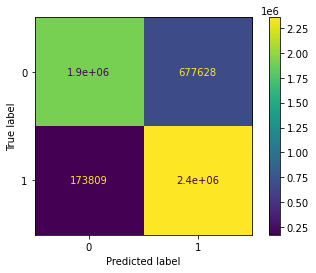

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ls = [0, 1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot()
plt.show()